# Wave functions

The basic abTEM multislice algorithm works by propagating the `xy` part of the wave function forward through an electrostatic potential one thin slice at a time (see Appendix 1 for a full derivation).

The `Waves` object wraps a complex numpy array representing an arbitrary wave function on a grid (given by $\phi$ in Appendix 1). Here is how to define a plane wave on a $512 \times 512$ grid, a lateral extent of $10\times 10$ $\mathrm{Å}^2$ and an energy of 300 keV:

In [1]:
from abtem.waves import Waves
import numpy as np

complex_array = np.ones((512, 512), dtype='complex64')

waves = Waves(complex_array, extent=10, energy=300e3)

The complex array can be accessed through the `array` property. 

In [2]:
waves.array is complex_array

True

The real-space sampling, or pixel size, is calculated by dividing the extent by the number of grid points. The properties related to the grid, i.e. the extent, grid points and sampling can be accessed as:

In [3]:
waves.extent, waves.gpts, waves.sampling

((10.0, 10.0), (512, 512), (0.01953125, 0.01953125))

To facilitate the creation of wave functions, abTEM includes a number of wave function builders. For example, the above is more easily accomplished by writing:

In [5]:
from abtem.waves import PlaneWave
waves = PlaneWave(gpts=512, extent=10, energy=300e3)
waves = waves.build()

np.all(waves.array == 1. + 0.j)

True

## Real-space sampling

The real-space sampling is extremely important because it controls the accuracy of the simulation at high scattering angles. The sampling defines the maximum spatial frequency $k_{max}$ via the formula:

$$ k_{max} = \frac{1}{2p} \quad , $$

where $p$ is the real-space sampling distance. To counteract aliasing artifacts due to the periodicity assumption of a discrete Fourier transform, abTEM supresses spatial frequencies above 50 % of the maximum scattering angle, further reducing the maximum effective scattering angle by a factor of 2. Hence the maximum scattering angle $\alpha_{max}$ is given by:

$$ \alpha_{max} = \frac{\lambda}{4p} \quad , $$

where $\lambda$ is the relativistic electron wavelength. As an example, consider a case where we want to simulate 80 keV electron scattering up to angles of 200 mrads. Plugging these values into the above equation gives a sampling of $\sim0.052$ Å, i.e. we require at least 0.05 Å pixel size in order to reach a maximum scattering angle of 200 mrads. In practice, you should ensure that the simulation is converged with respect to pixel size.

<div class= "alert alert-info">

**Note: Units**

abTEM uses the same unit conventions as ASE, as defined in the `ase.units` module. Thus, electron volts (eV), Ångström (Å), and atomic mass units are defined as 1.0. The electrostatic potential is given in (eV / e). Angles in abTEM are for convenience given in milliradians (mrad).
  
</div>

## Probe wave functions

In STEM, the wave function is a focused beam of electrons. The convention used in abTEM is a probe defined by

$$
    \phi(k) = A(k) E(k) \exp(-i \chi(k)) \quad ,
$$

where $A(k)$ is the condenser aperture function, $E(k)$ is the partial coherence envelope and $\chi(k)$ is the phase error. A detailed description of each term is given in the discussion of the Contrast Tranfer Function. 

We create a probe with a sampling of $0.05 \ \mathrm{Å}$, an extent of $10\times 10$ $\mathrm{Å}^2$, an energy of $60 \ \mathrm{keV}$, a convergence semiangle of $30 \ \mathrm{mrad}$, a focal spread of of $30 \ \mathrm{Å}$ and defocus of $50 \ \mathrm{Å}$. 

In [6]:
from abtem.waves import Probe
probe = Probe(sampling=.05, 
               extent=10, 
               energy=60e3, 
               semiangle_cutoff=30, 
               focal_spread=30,
               defocus=50)

We can build a batch of three probes at different positions.

In [12]:
positions = [(0, 0), (2.5, 2.5), (5, 5)]
waves = probe.build(positions)

The last two dimensions of a waves object represent the spatial dimensions. Preceeding dimensions may represent other aspects, usually a batch dimension. Batching can speed up calculations significantly by propagating multiple wave functions simulaneously.

The dimensions preceeding the last two diemensions of the `Waves` object can be sliced.

In [13]:
wave = waves[1]

waves.array.shape, wave.array.shape

((3, 200, 200), (200, 200))

The wave function can be visualized using the `.show` method.

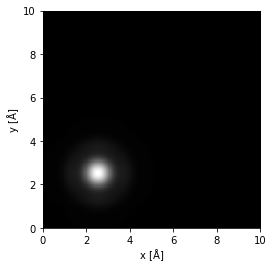

In [14]:
wave.show()

<div class= "alert alert-info">

**Note: Axes convention**

The axes convention for arrays representing a wave functions assigns the first axis to the $x$-axis and the second axis to the $y$-axis, and a larger array index implies a larger real-space coordinate. This is different from the convention often used for images. The correct way of displaying an array with `matplotplib` is given below.
    
```
import matplotlib.pyplot as plt
image = np.abs(waves.array[0]) ** 2
plt.imhow(image.T, extent=[0, waves.extent[0], 0, waves.extent[1]], origin='lower')
```     
  
</div>